# Installations / Préparations

## install

In [31]:
!pip install importlib-metadata==4.13.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [32]:
!pip install git+https://github.com/osigaud/bbrl_gym

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/osigaud/bbrl_gym to /tmp/pip-req-build-cfma7rkr
  Running command git clone --filter=blob:none --quiet https://github.com/osigaud/bbrl_gym /tmp/pip-req-build-cfma7rkr
  Resolved https://github.com/osigaud/bbrl_gym to commit 5557075ecd7d4171ac0c21be3c69a94bcae655a9
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached mazemdp-0.7.3-py3-none-any.whl (15 kB)
  Attempting uninstall: mazemdp
    Found existing installation: mazemdp 0.1.dev146+g32a8f61
    Uninstalling mazemdp-0.1.dev146+g32a8f61:
      Successfully uninstalled mazemdp-0.1.dev146+g32a8f61


In [33]:
#!pip install git+https://github.com/patrolSU2019/SimpleMazeMDP

## import

In [34]:
import os
from typing import Tuple, List

import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from mazemdp.toolbox import egreedy, egreedy_loc
from mazemdp.toolbox import softmax, sample_categorical
from mazemdp.maze_plotter import show_videos
from mazemdp.mdp import Mdp
from bbrl_gym.envs.maze_mdp import MazeMDPEnv

# For visualization
os.environ["VIDEO_FPS"] = "5"
if not os.path.isdir("./videos"):
    os.mkdir("./videos")

from IPython.display import Video

import gym
import bbrl_gym

## settings

In [60]:
# Settings
MAZE_LARGEUR = 4
MAZE_HAUTEUR = 3
RATIO = 0.25

NB_EPISODES = 500
TIMEOUT = 100
EPSILON = 0.02
TAU = 0.1
ALPHA = 0.5

## création du maze

In [36]:
env = gym.make("MazeMDP-v0", kwargs={"width": MAZE_LARGEUR, "height": MAZE_HAUTEUR, "ratio": RATIO})
env.reset()

# in dynamic programming, there is no agent moving in the environment
env.init_draw("The maze")

Output()

# Q-Learning 3D

## utils

In [37]:
# Renvoie la meilleure policy pour un but donné
def get_policy_from_q(Q: np.ndarray, but: int) -> np.ndarray:
    # Outputs a policy given the action values
    policy = np.argmax(Q[:, but, :], axis=1)
    return policy

In [38]:
# calcul la matrice de trnasition adéquate pour un but donné
def calcul_transition(mdp: MazeMDPEnv, but):
    transition_matrix = np.zeros( (mdp.nb_states, mdp.action_space.n, mdp.nb_states) )

    for s in range(mdp.nb_states-1):
        x = mdp.coord_x[s]
        y = mdp.coord_y[s]

        # NORD #
        # si case tout au nord, pas de changement d'état possible dans cette direction
        if x == 0 :
            transition_matrix[s][0][s] = 1.0
        # SUD #
        # si case tout au sud, pas de changement d'état possible dans cette direction
        if x == MAZE_HAUTEUR-1 :
            transition_matrix[s][1][s] = 1.0
        # EST #
        # si case tout à l'est, pas de changement d'état possible dans cette direction
        if y == MAZE_LARGEUR-1 :
            transition_matrix[s][2][s] = 1.0
        # OUEST
        # si case tout à l'ouest, pas de changement d'état possible dans cette direction
        if y == 0 :
            transition_matrix[s][3][s] = 1.0

        for s_prime in range(mdp.nb_states-1):
            # Regarde les relations entre s et les autres états
            if (s != s_prime):
                x_prime = mdp.coord_x[s_prime]
                y_prime = mdp.coord_y[s_prime]
                # NORD #
                if (x_prime == x-1) and (y_prime == y):
                    transition_matrix[s][0][s_prime] = 1.0
                # SUD #
                if (x_prime == x+1) and (y_prime == y):
                    transition_matrix[s][1][s_prime] = 1.0
                # EST #
                if (x_prime == x) and (y_prime == y+1):
                    transition_matrix[s][2][s_prime] = 1.0
                # OUEST #
                if (x_prime == x) and (y_prime == y-1):
                    transition_matrix[s][3][s_prime] = 1.0

        # Si une action n'a aucune transition, alors on boucle sur le même état
        for a in range(mdp.action_space.n):
            if all(transition_matrix[s,a] == 0):
                transition_matrix[s,a,s] = 1.0

    # Transition Matrix of terminal states
    transition_matrix[but, :, :] = 0
    transition_matrix[but, :, -1] = 1

    return transition_matrix

In [39]:
# calcul et stocke les matrices de récompense et de transition pour un but donné
def calcul_goal(mdp: MazeMDPEnv, but: int):
    # calcul du nouveau point d'origine des récompenses
    new_r = np.zeros((mdp.nb_states, mdp.action_space.n))
    new_r[but] = np.ones(mdp.action_space.n)
    new_r[but] = np.ones(mdp.action_space.n)

    # calcul de la nouvelle matrice de transition
    new_P = calcul_transition(mdp, but)

    return new_r, new_P

In [40]:
# modifie la MDP en fonction du goal
def maj_goal(mdp: MazeMDPEnv, but, r_list, P_list):
    # modification de l'état but
    mdp.mdp.r = r_list[but]
    mdp.P = P_list[but]
    mdp.mdp.P = P_list[but]

## Epsilon-greedy

### algo

In [51]:
# --------------------------- Q-Learning epsilon-greedy version -------------------------------#

# Given an exploration rate epsilon, the QLearning algorithm computes the state action-value function
# based on an epsilon-greedy policy
# alpha is the learning rate


def ql_3d_eps(
    mdp: MazeMDPEnv,
    epsilon: float,
    nb_episodes: int = 20,
    timeout: int = 50,
    alpha: float = 0.5,
    render: bool = True,
) -> Tuple[np.ndarray, List[int]]:
    # Initialize the state-goal-action value function
    # 3D : états / buts / actions
    Q = np.zeros((mdp.nb_states, mdp.nb_states, mdp.action_space.n))
    r_list = []   # récompenses selon les buts
    P_list = []   # transition selon les buts
    t_list = []   # étape par episode

    # calcul initial des matrices pour chacun des buts
    for s in range(mdp.nb_states-1):
        new_r, new_P = calcul_goal(mdp, s)
        r_list.append(new_r)
        P_list.append(new_P)
  
    # Run learning cycle
    mdp.timeout = timeout  # episode length

    if render:
        mdp.init_draw("Q-learning e-greedy")

    for _ in tqdm(range(nb_episodes)):
        # Draw the first state of episode i using a uniform distribution over all the states
        s = mdp.reset(uniform=True)
        but = np.random.randint(mdp.nb_states-1)   # tirage de l'état but (hors état puit)

        maj_goal(mdp, but, r_list, P_list)    # modification des matrices correspondante à ce but

        done = mdp.mdp.done()

        while not done:
            if render:
                # Show the agent in the maze
                mdp.mdp.plotter.terminal_states = [but]    # modifie le plotter
                mdp.draw_v_pi(Q[:,but,:], get_policy_from_q(Q, but))

            # Draw an action using an epsilon-greedy policy
            a = egreedy(Q[:, but, :], s, epsilon)

            # Perform a step of the MDP
            [s_prime, r, done, _] = mdp.step(a)

            # Calculs en fonction du but de l'épisode
            delta = r + mdp.gamma * np.max(Q[s_prime, but]) - Q[s, but, a]

            Q[s, but, a] += alpha * delta

            # Update the agent position
            s = s_prime
        t_list.append(mdp.mdp.timestep)

    return Q, t_list

In [42]:
Q, _ = ql_3d_eps(env, EPSILON, NB_EPISODES, TIMEOUT)

Output()

  0%|          | 0/100 [00:00<?, ?it/s]

### Visualisation epsilon-greedy

In [44]:
show_videos("videos/", "Q-learninge-greedy")

In [45]:
# visualisation
but = 3
print("état but : ", but)
env.mdp.plotter.terminal_states = [but]
env.draw_v_pi(Q[:,but,:], get_policy_from_q(Q, but), title="Q-learning e-greedy"+str(but))

état but :  3


Output()

## Softmax

### algo

In [52]:
# --------------------------- Q-Learning softmax version ----------------------------#

# Given a temperature "tau", the QLearning algorithm computes the state action-value function
# based on a softmax policy
# alpha is the learning rate


def ql_3d_soft(
    mdp: MazeMDPEnv,
    tau: float,
    nb_episodes: int = 20,
    timeout: int = 50,
    alpha: float = 0.5,
    render: bool = True,
) -> Tuple[np.ndarray, List[int]]:
    # Initialize the state-action value function
    # alpha is the learning rate
    Q = np.zeros((mdp.nb_states,mdp.nb_states, mdp.action_space.n))

    r_list = []
    P_list =[]
    t_list = []

    # calcul initial des matrices pour chacun des buts
    for s in range(mdp.nb_states-1):
        new_r, new_P = calcul_goal(mdp, s)
        r_list.append(new_r)
        P_list.append(new_P)
    

    # Run learning cycle
    mdp.timeout = timeout  # episode length

    if render:
        mdp.init_draw("Q-learning softmax")

    for episode in tqdm(range(nb_episodes)):
        # Draw the first state of episode i using a uniform distribution over all the states
        x = mdp.reset(uniform=True)
        but = np.random.randint(0,mdp.nb_states-1)

        maj_goal(mdp, but, r_list, P_list)

        # on explore moins au fil des épisodes
        #t = tau / (1 + np.log(1+episode))

        done = mdp.mdp.done()
        while not done:
            if render:
                # Show the agent in the maze
                mdp.mdp.plotter.terminal_states = [but]
                mdp.draw_v_pi(Q[:,but,:], get_policy_from_q(Q, but))

            u = sample_categorical(softmax(Q[:, but, :], x, tau))
            # Perform a step of the MDP
            [y, r, done, _] = mdp.step(u)

            # Update the state-action value function
            delta = r + mdp.gamma * np.max(Q[y, but]) - Q[x, but, u]
            Q[x,but, u] = Q[x,but, u] + alpha * delta
            
            x = y
        t_list.append(mdp.mdp.timestep)

    return Q, t_list

In [49]:
q = ql_3d_soft(env, TAU, NB_EPISODES, TIMEOUT)

Output()

  0%|          | 0/100 [00:00<?, ?it/s]

### Visualisation Softmax

In [53]:
show_videos("videos/", "Q-learningsoftmax")

Converting videos/Q-learningsoftmax.avi


In [54]:
# visualisation
but = 4
print("état but : ", but)
env.mdp.plotter.terminal_states = [but]
env.draw_v_pi(q[:,but,:], get_policy_from_q(q, but), title="Q-learning e-greedy"+str(but))

état but :  4


Output()

## Courbes d'apprentissages

In [55]:
def plot_ql_3d_goal(env, epsilon, tau, nb_episodes, timeout, alpha, render):
    q, t_list1 = ql_3d_eps(env, epsilon, nb_episodes, timeout, alpha, render)
    q, t_list2 = ql_3d_soft(env, tau, nb_episodes, timeout, alpha, render)

    plt.figure(figsize=(18,5))
    plt.plot(range(nb_episodes), t_list1, label='q-learning epsilon')
    plt.plot(range(nb_episodes), t_list2, label='q-learning softmax')
    plt.xlabel('Number of episodes')
    plt.ylabel('Number of steps to reach the goal')
    plt.legend(loc='upper right')
    plt.title("Comparison of Time to reach the goal")
    plt.show()

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

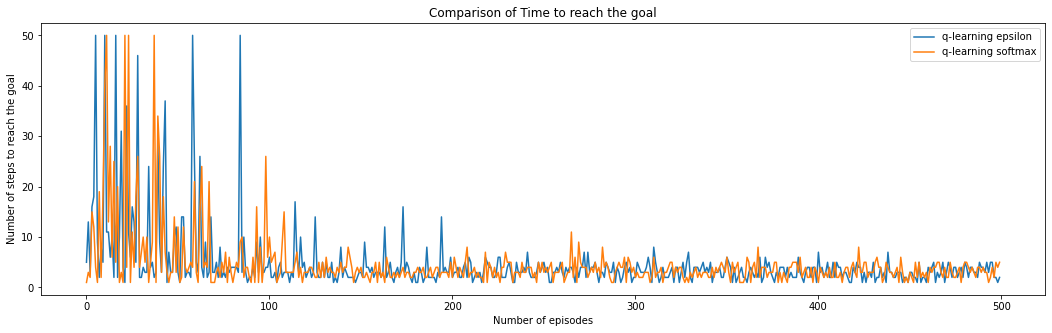

In [61]:
plot_ql_3d_goal(env, EPSILON, TAU, NB_EPISODES, TIMEOUT, ALPHA, False)